In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [51]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [15]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [21]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [24]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [26]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Perip = Base.classes.measurement

In [59]:
# Calculate the date 1 year ago from today, cant use this though because the data is too old...
last_year = (dt.date.today() - dt.timedelta(days=365))
             
# Perform a query to retrieve the data and precipitation scores
date = []
precip = []
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all():
    date.append(row[0])
    precip.append(row[1])

# Save the query results as a Pandas DataFrame and set the index to the date column, and sort by date
precip_df = pd.DataFrame({'Date': date,
                          'Precipitation': precip
                         })
precip_df.set_index('Date').sort_values(by=['Date'], ascending=False).head(5)

,Precipitation
Date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.00


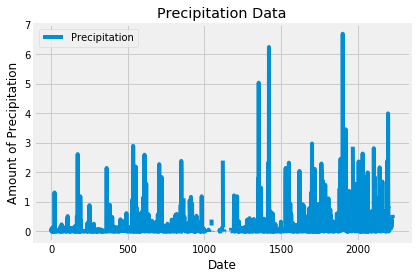

In [60]:
precip_df.plot()
plt.ylabel('Amount of Precipitation')
plt.xlabel('Date')
plt.title('Precipitation Data')
plt.show()

# Exploratory Climate Analysis

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [64]:
# Design a query to show how many stations are available in this dataset?
uni_stations = session.query(Station.id).distinct().count()
print(f"There are {uni_stations} Stations in the dataset")

There are 9 Stations in the dataset


In [63]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

engine.execute('SELECT m.station, count(m.id) FROM measurement m GROUP BY m.station ORDER BY 2 DESC').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [66]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'For Station {temps[0][0]} the highest temp recorded was {temps[0][1]} degrees, the lowest temp recorded was {temps[0][2]} degrees, and the average temp was {round(temps[0][3])}.')

For Station USC00519281 the highest temp recorded was 85.0 degrees, the lowest temp recorded was 54.0 degrees, and the average temp was 72.


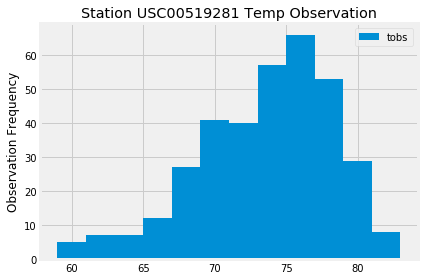

In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_obs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
obs_df = pd.DataFrame(highest_obs)
obs_df.head(3)
obs_df.plot.hist(bins=12)
plt.ylabel("Observation Frequency")
plt.title("Station USC00519281 Temp Observation")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2013-06-28', '2013-9-05'))

[(61.0, 74.26700804681785, 86.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_bar = calc_temps('2016-08-23', '2017-08-23')
print(temp_bar)

[(58.0, 74.59058295964125, 87.0)]


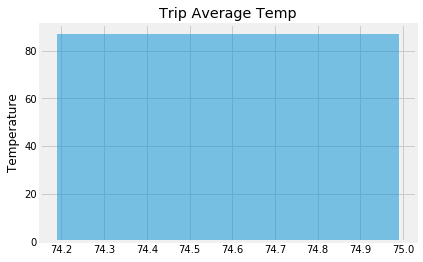

In [76]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(temp_bar[0][1], temp_bar[0][2], align='center', alpha=0.5)
plt.ylabel('Temperature')
plt.title('Trip Average Temp')

plt.show()

In [80]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = "2017-03-01"
end_date = "2017-03-14"
[temp_min, temp_avg, temp_max] = calc_temps(start_date, end_date)

print(f"My trip starts on {start_date} and ends on {end_date}. \
For the range of dates, the min temperature is {temp_min}, \
mean temperature is {temp_avg}, and maximum temperature is {temp_max}.")

ValueError: not enough values to unpack (expected 3, got 1)

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


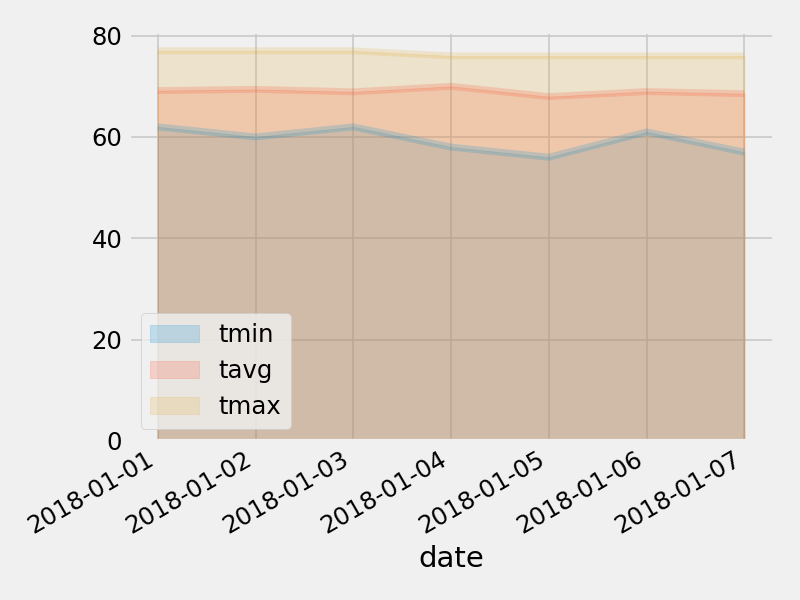

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
